<a href="https://colab.research.google.com/github/james-t-little/cnn_diss_repo/blob/main/code/city_osm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
SEED = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

# used to mount the data repository to the google colab session
drive.mount('/content/drive')

path = '/content/drive/MyDrive/dissertation_seg_data'

# assigns a location path to both the image and mask of the segementation data
image_path = os.path.join(path,"input_resize_patches/")
mask_path = os.path.join(path,"mask_resize_patches/")

Mounted at /content/drive


In [3]:
def load_image(image_path):
    # open image
    image = tf.io.read_file(image_path)
    # decodes image into RGB png
    image = tf.image.decode_png(image, channels=3)
    # changes dtype of image to int
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # change input path to mask path
    mask_path = tf.strings.regex_replace(image_path, "image", "labels")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")
    # open mask
    mask = tf.io.read_file(mask_path)
    # decodes mask into grayscale png
    mask = tf.image.decode_png(mask, channels = 1)

    # 255 - White (Other)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # 76 - Grey (Building)
    mask = tf.where(mask == 76, np.dtype('uint8').type(1), mask)
    # 29 - Black (Road)
    mask = tf.where(mask == 29, np.dtype('uint8').type(2), mask)
    # change anomaly pixels to class 0
    mask = tf.where(tf.math.logical_and(tf.math.logical_and(mask != 0, mask != 1), mask != 2), np.dtype('uint8').type(0), mask)

    return {'image' : image, 'mask': mask}

In [4]:
dataset = tf.data.Dataset.list_files(image_path + "*.png")

# split data into train
train_size = 0.8 * dataset.cardinality().numpy()

train_ds = dataset.take(train_size)

# split data into validation
validation_size = 0.1 * dataset.cardinality().numpy()

extra = dataset.skip(train_size)  

val_ds = extra.take(validation_size)

test_ds = extra.skip(validation_size)

# parse image/mask for each dataset
train_ds = train_ds.map(load_image)

test_ds = test_ds.map(load_image)

val_ds = val_ds.map(load_image)

In [5]:
# used to prepare training data
def process_image(data_pair):

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(data_pair['image'])
        mask = tf.image.flip_up_down(data_pair['mask'])
    else:
        image = data_pair['image']
        mask = data_pair['mask']

    image = tf.cast(image, tf.float32) / 255.0

    return image, mask

# used to prepare validation and test data
def process_image_alt(data_pair):

    image = tf.cast(data_pair['image'], tf.float32) / 255.0

    return image, data_pair['mask']

In [13]:
# initialise hyper-parameters
IMAGE_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 100
BUFFER_SIZE = 1000

# create and batch each dataset
data = {"train": train_ds, "test": test_ds, "val": val_ds}

data['train'] = data['train'].map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

data['val'] = data['val'].map(process_image_alt).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

data['test'] = data['test'].map(process_image_alt).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [14]:
# convolutional block used for both encoder and decoder
def convolutional_block(prev, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(prev)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

# u-net method
def u_net_seg_model(img_shape, n_classes, filter_start):
    # input layer with defined shape
    input_layer = Input(shape=img_shape)
    x = input_layer

    # number of filters defined at each U-Net layer
    filter_list = [filter_start, filter_start * 2, filter_start * 4, filter_start * 8]

    # create skip connection
    skip = []

    # iterate through each layer of the encoder block
    for filter_size in filter_list:
        x = convolutional_block(x, filter_size, (3,3))
        skip.append(x)
        x = MaxPooling2D((2, 2))(x)

    # reverse the skip connection list
    skip = list(reversed(skip))

    # bridge connection
    x = convolutional_block(x, filter_start * 8, (3,3))

    # iterate up through each layer of the decoder block
    for count,filter_size in enumerate(reversed(filter_list)):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip[count]])
        convolutional_block(x, filter_size, (3,3))


    # select output activation function depend on whether the output is binary (sigmoid) or multi-class (softmax)
    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    # output layer
    output_layer = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(x)

    return Model(inputs=input_layer, outputs=output_layer)

# create model with selected parameters
model = u_net_seg_model((IMAGE_SIZE, IMAGE_SIZE, 3), n_classes = 3, filter_start = 32)

In [15]:
# compile model with optimiser, loss and metrics 
# loss metric needed to reflect the output of the model data - multi_class = categorical crossentropy 
# sparse is used due to nature of the preprocessing on the ground truth mask
model.compile(optimizer=Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
# callback saving the model each time it achieves a better loss value
callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+"e65_bs16.h5"), verbose = 1, save_best_only=True, save_weights_only=False)]

In [17]:
# calculate number of steps per epoch and validation steps
length_data = train_ds.cardinality().numpy()

length_val = val_ds.cardinality().numpy()

STEPS_PER_EPOCH = length_data // BATCH_SIZE

VALIDATION_STEPS = length_val // BATCH_SIZE

In [ ]:
# run the U-Net model
model_history = model.fit(data['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=data['val'], validation_steps=VALIDATION_STEPS, callbacks = callbacks)

In [19]:
# model metrics during training
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

# function to plot metrics
def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()

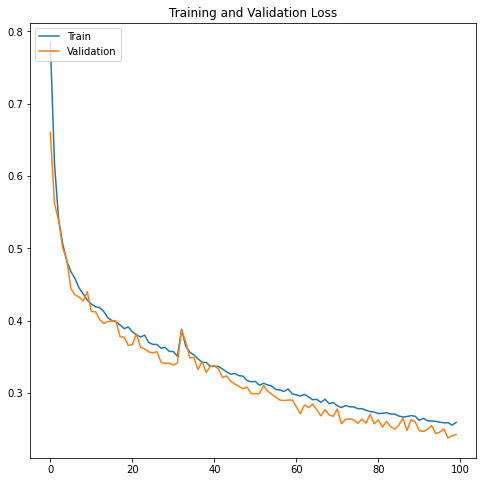

In [20]:
# loss graph
plot_training_data("Training and Validation Loss", loss, val_loss)

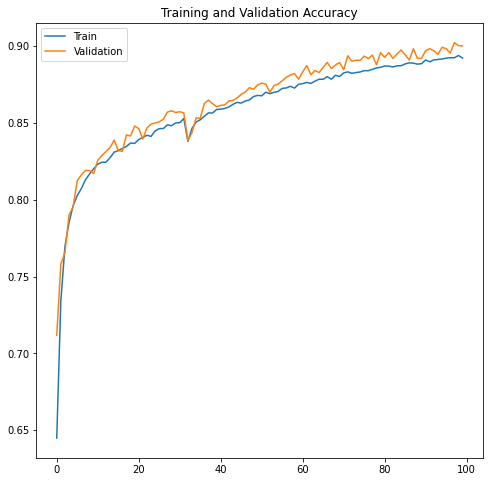

In [21]:
# accuracy graph
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

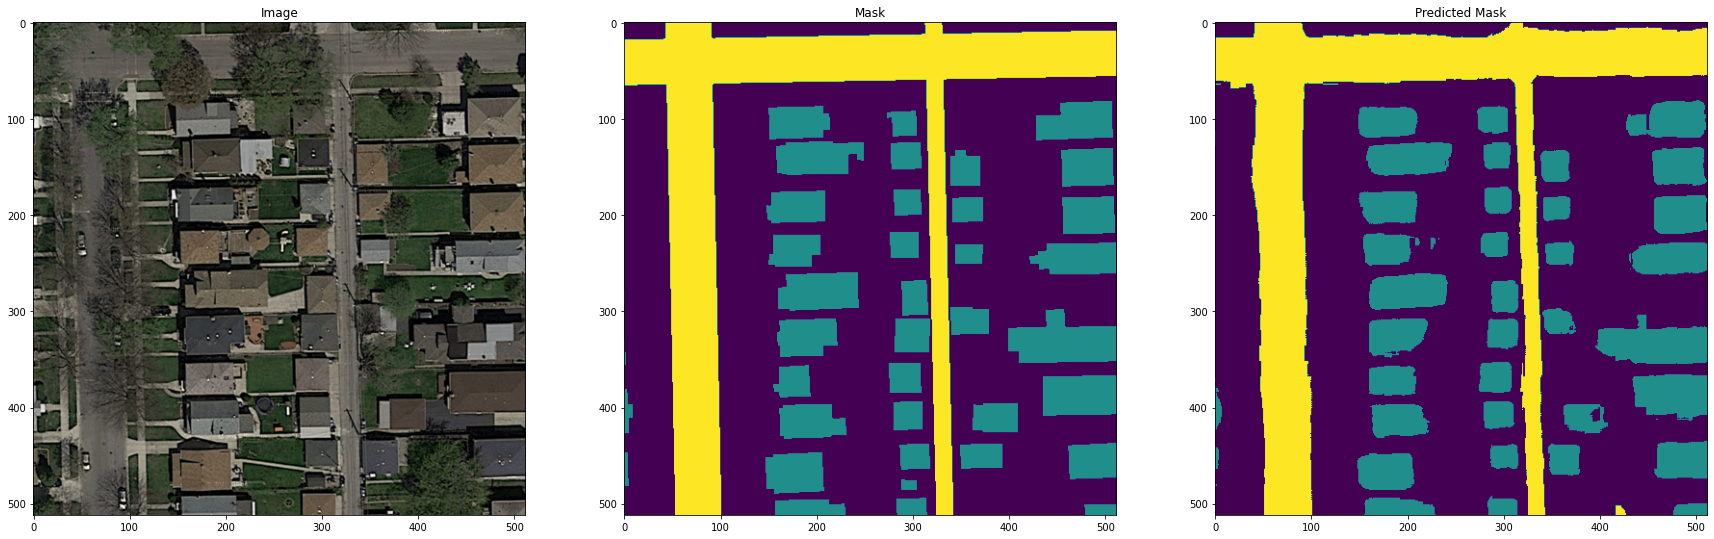

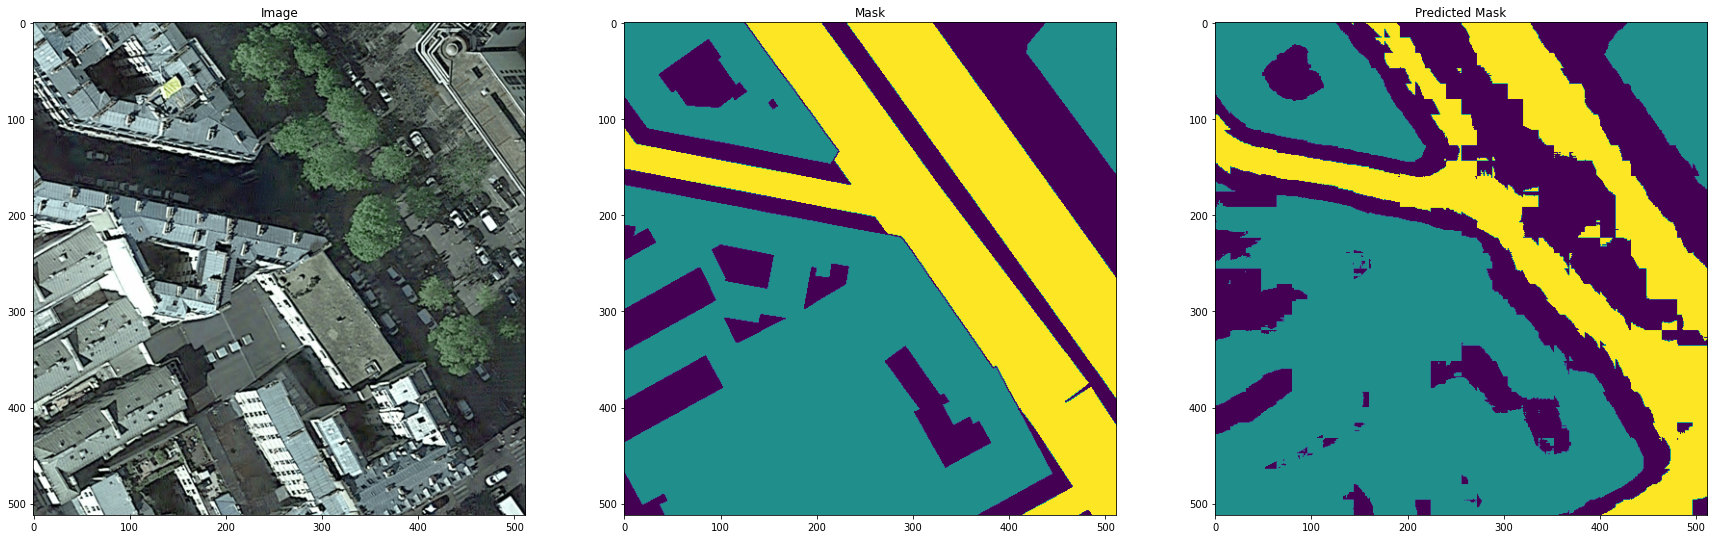

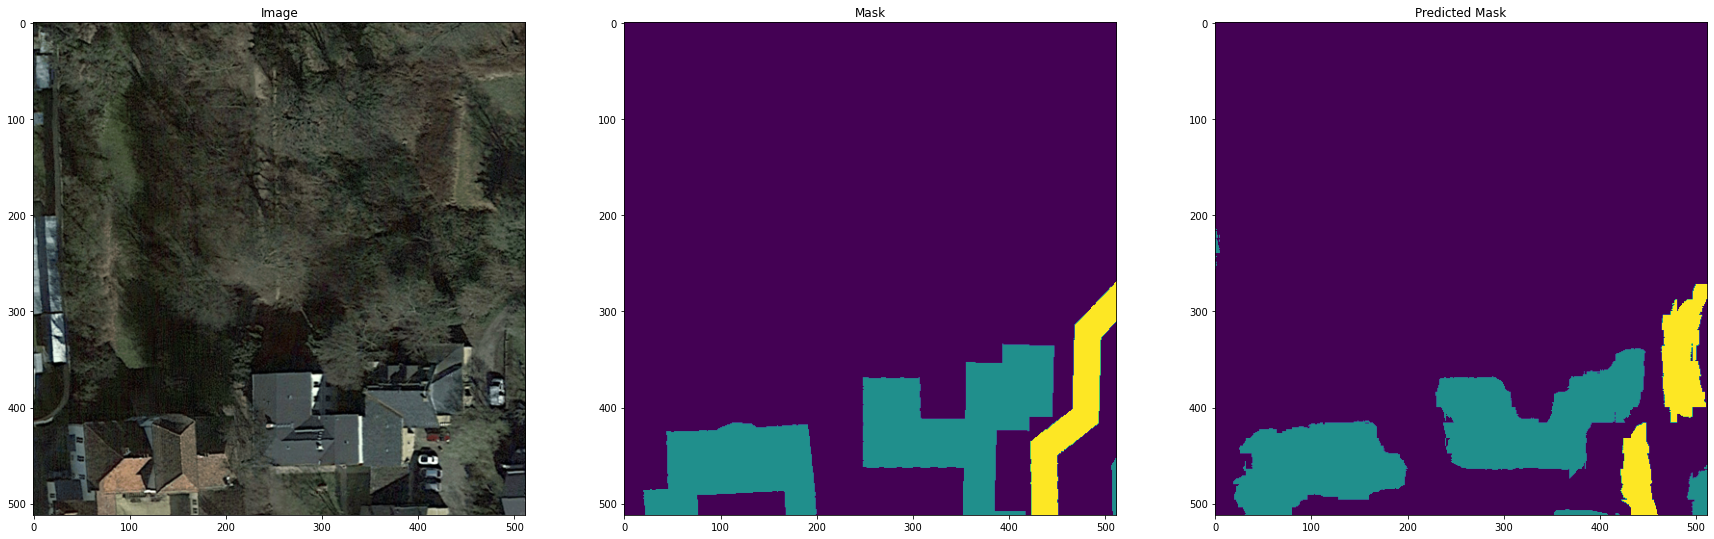

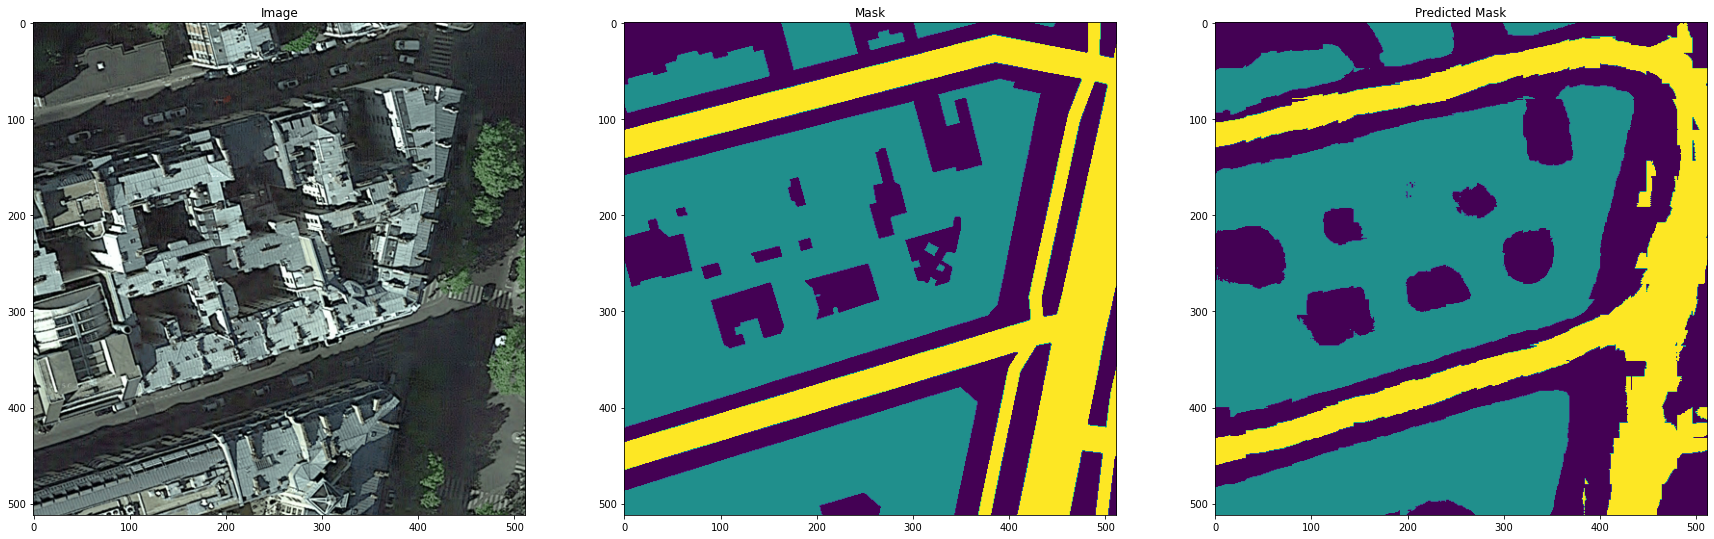

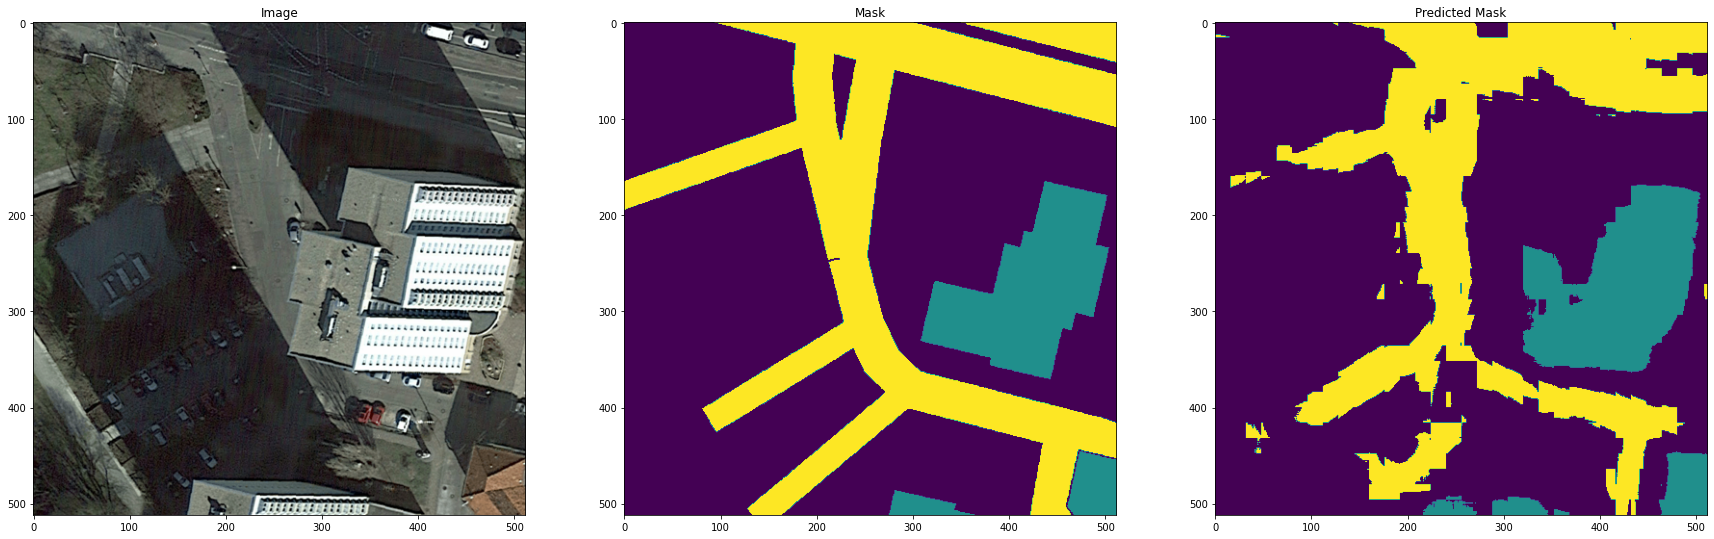

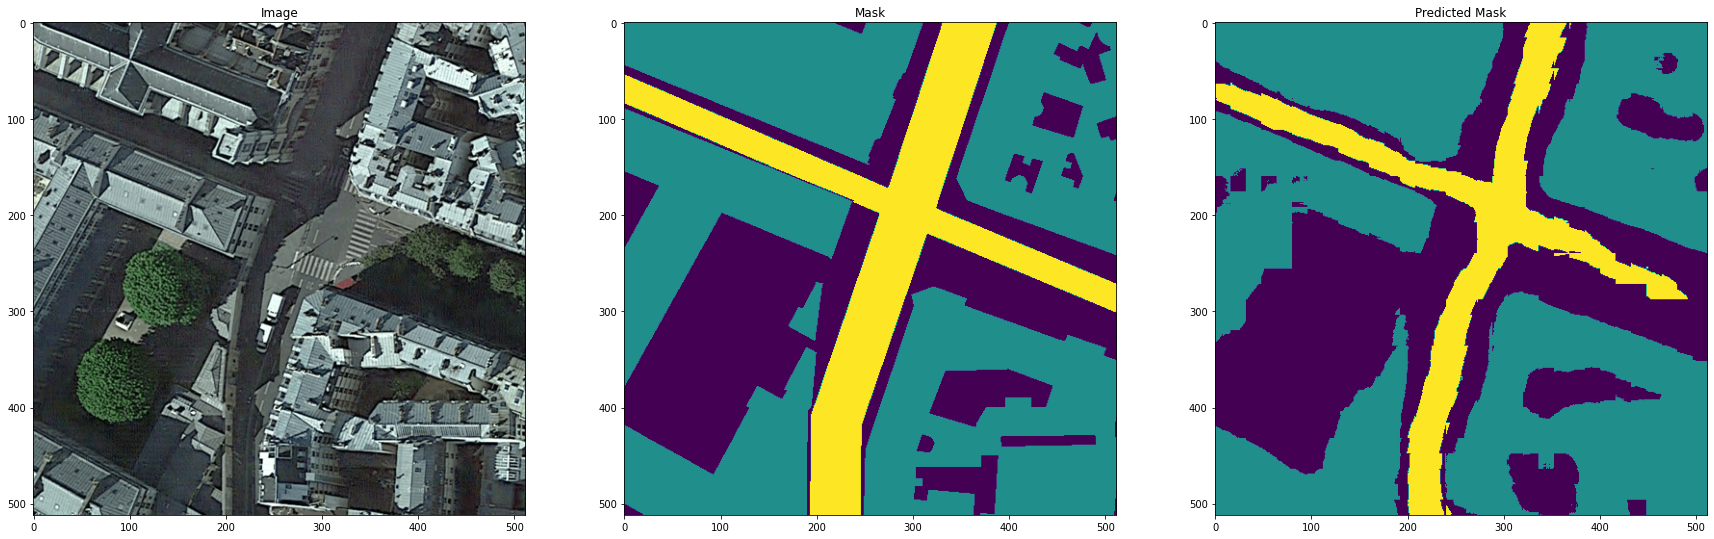

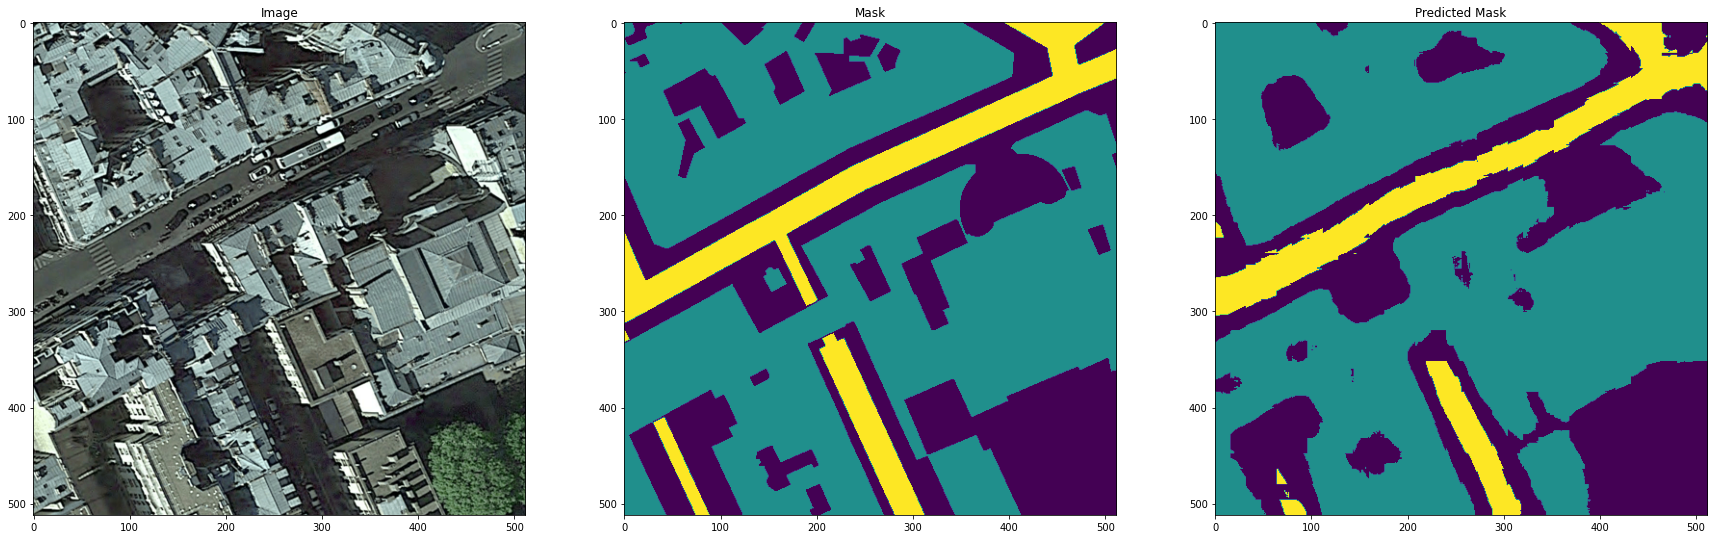

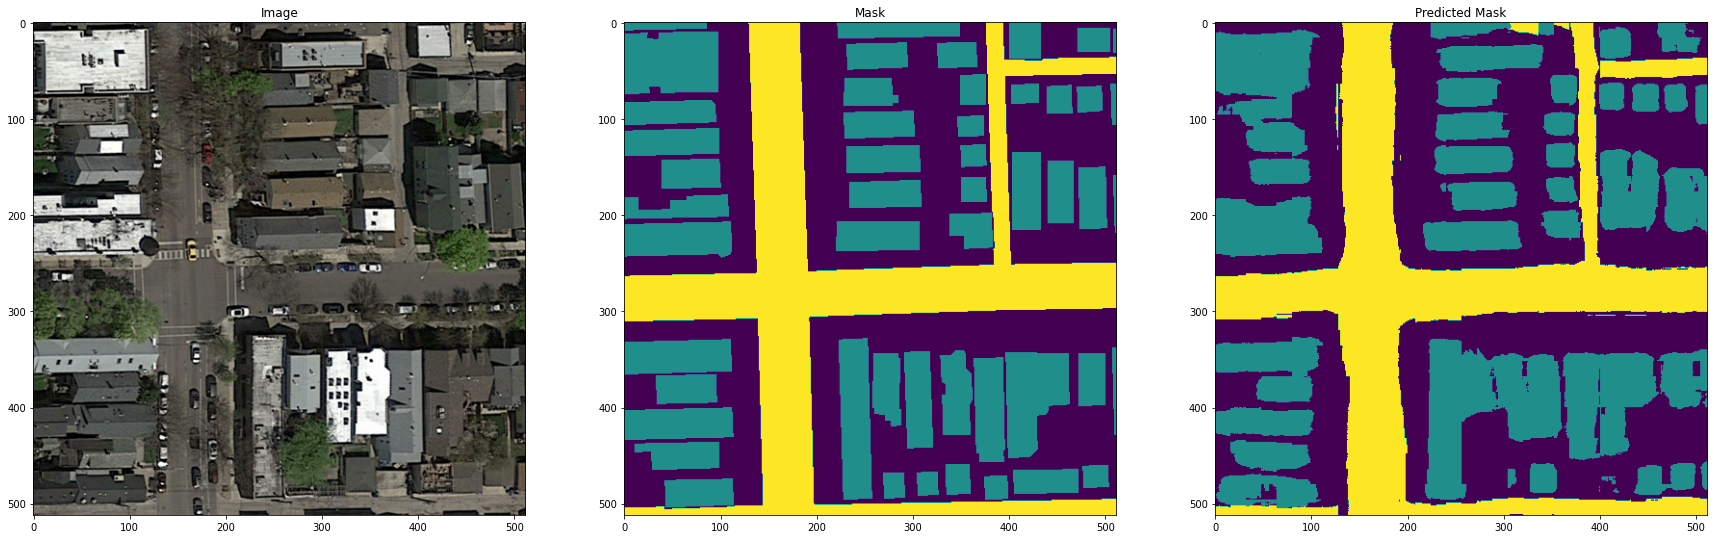

In [43]:
# graph the prediction of an image, ground truth mask and predicted mask
def plot_predictions(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,3,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))
    plt.title('Predicted Mask')
    plt.show()

# format the prediction to be plot
def format_prediction(pred_mask):
    # remove probabilities and replace with class
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# randomly select half a batch of images from the data to create a segmentation using the U-Net
for image, mask in data['test'].take(1):
    for i in range(BATCH_SIZE//2):
        pred_mask = model.predict(image)
        pred_mask = format_prediction(pred_mask[i])
        plot_predictions(image[i], mask[i], pred_mask)